In [32]:
import pandas as pd
import matplotlib.pyplot as plt

#plt.rcParams["figure.figsize"] = (25,15)

import seaborn as sns
sns.set()
sns.set_style("darkgrid")


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
plt.rcParams.update(params)


# Read in latest data

Makefile has tasks for pulling from CovidTracking.com api

Need to download current season file from https://gis.cdc.gov/grasp/fluview/mortality.html and run make task to

In [33]:
weekOrder = [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39]

usDaily = pd.read_json('file:///home/jovyan/work/datasets/CovidTrackingUsDaily.json')

usFluHistorical = pd.read_csv('file:///home/jovyan/work/datasets/National_Historical_Flu_Mortality.csv', thousands=',')
usFluCurrent = pd.read_csv('file:///home/jovyan/work/datasets/National_Current_Flu_Mortality.csv', thousands=',')
usFlu = pd.concat([usFluHistorical, usFluCurrent])

usFlu['SEASON'] = usFlu['SEASON'].astype('category')
usFlu['WEEK'] = usFlu['WEEK'].astype('category')

# Checking out the severity of flu seasons

Plot of all the flu deaths for each season

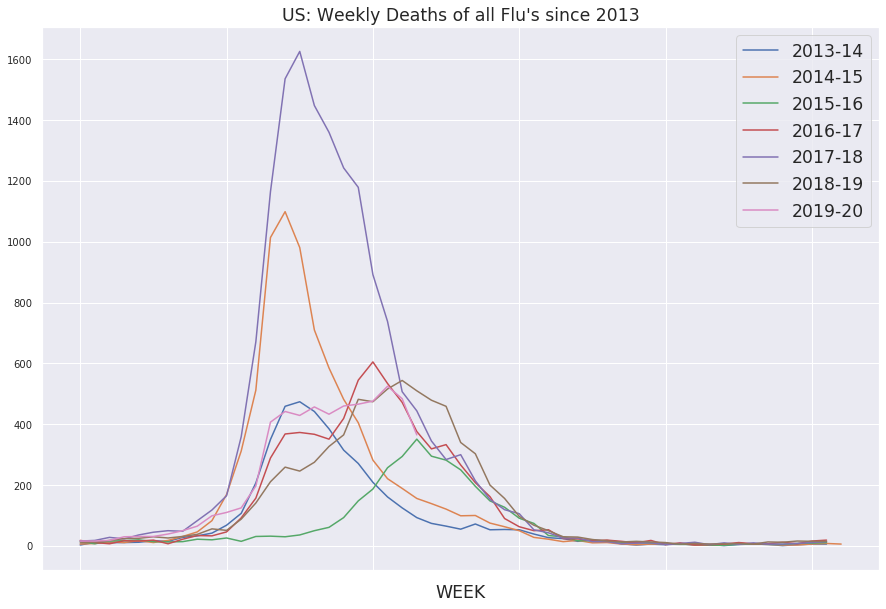

In [34]:
ax = plt.gca()
ax.set_title("US: Weekly Deaths of all Flu's since 2013")

groups = usFlu.groupby('SEASON')

for k,v in groups:
    v.plot(label=k, kind='line', x='WEEK', y='NUM INFLUENZA DEATHS', ax=ax)

plt.savefig('covid_images/US_All_Flu_Mortality_Comparison.png', dpi=300)

# Singular view of 2017-18 flu season

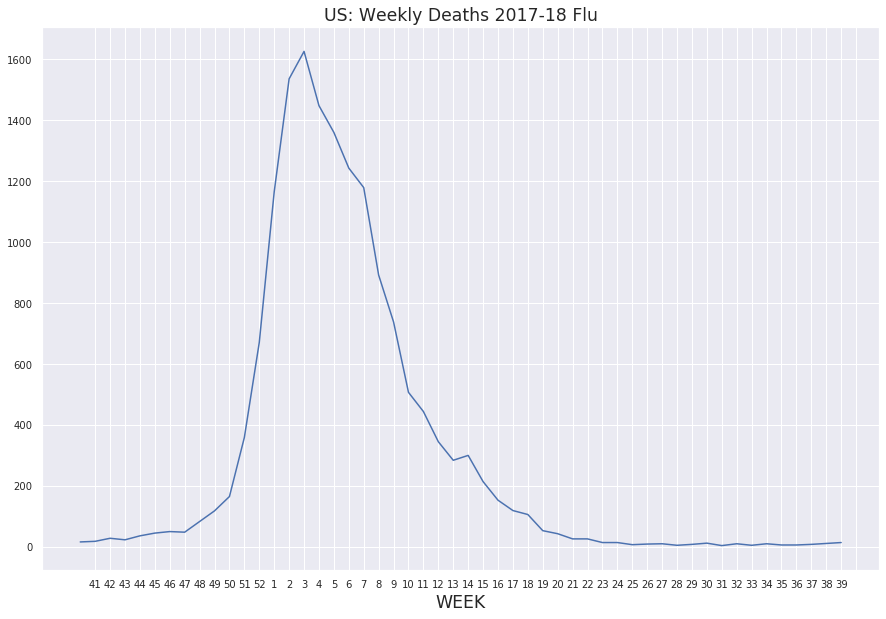

In [35]:
ax = plt.gca()
ax.set_title('US: Weekly Deaths 2017-18 Flu')


worstFluSeason = usFlu[usFlu['SEASON'] == '2017-18']

worstFluSeason.plot(kind='line', x='WEEK', y='NUM INFLUENZA DEATHS', xticks=weekOrder, legend=False, ax=ax)

# Aggregate the CovidTracking data by week

In [36]:
usDaily['date'] = pd.to_datetime(usDaily['date'], format='%Y%m%d')

usDaily['dayOfYear'] = usDaily['date'].dt.strftime('%j')
usDaily['dayOfYear'] = usDaily['dayOfYear'].astype('int')


usDaily['week'] = pd.to_datetime(usDaily['date'] - pd.to_timedelta(7, unit='d'))
usDaily['week'] = usDaily['week'].dt.strftime('%W')

usDaily['week'] = usDaily['week'].astype('category')
col = usDaily.pop("week")
col = col.astype('int') + 2
usDaily.insert(0, col.name, col)

usDailyByWeek = usDaily.groupby(['week']).agg({'deathIncrease':'sum', 'hospitalizedIncrease':'sum', 'positiveIncrease':'sum', 'negativeIncrease':'sum', 'totalTestResultsIncrease':'sum'}).reset_index()

usDailyCurrentWeek = usDailyByWeek.tail(1)
usDailyByWeekExcludingCurrent = usDailyByWeek[:-1]

usDailyCurrentWeek

,week,deathIncrease,hospitalizedIncrease,positiveIncrease,negativeIncrease,totalTestResultsIncrease
4,14,1318.0,6930.0,45709.0,171911.0,217620.0


# Plot Covid Deaths With Worst Flu Season Deaths

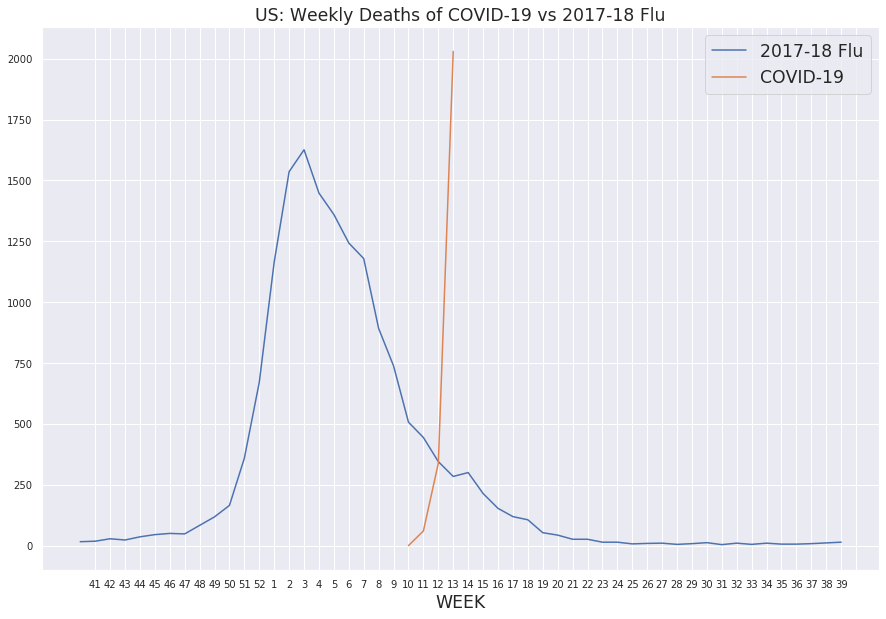

In [37]:
ax = plt.gca()
ax.set_title('US: Weekly Deaths of COVID-19 vs 2017-18 Flu')

worstFluSeason = usFlu[usFlu['SEASON'] == '2017-18']
merged = pd.merge(worstFluSeason, usDailyByWeekExcludingCurrent, how='left', left_on='WEEK', right_on='week')
merged['WEEK'] = merged['WEEK'].astype('category')


merged.plot(label='2017-18 Flu', kind='line', x='WEEK', y='NUM INFLUENZA DEATHS', xticks=weekOrder, ax=ax)
merged.plot(label='COVID-19', kind='line', x='WEEK', y='deathIncrease', ax=ax)

plt.savefig('covid_images/US_Weekly_COVID_Deaths_vs_Flu.png', dpi=300)

# Correlation of COVID data


 00-.19 "very weak"
 
.20-.39 "weak"

.40-.59 "moderate"

.60-.79 "strong"

.80-1.0 "very strong"

In [38]:
usDaily[['dayOfYear', 'deathIncrease', 'hospitalizedIncrease', 'negativeIncrease', 
         'positiveIncrease', 'totalTestResultsIncrease']].corr(method ='pearson')

,dayOfYear,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
dayOfYear,1.000000,0.817833,0.817502,0.935633,0.914708,0.935428
deathIncrease,0.817833,1.000000,0.894987,0.872625,0.944696,0.890295
hospitalizedIncrease,0.817502,0.894987,1.000000,0.918553,0.937275,0.926009
negativeIncrease,0.935633,0.872625,0.918553,1.000000,0.973694,0.999012
positiveIncrease,0.914708,0.944696,0.937275,0.973694,1.000000,0.982858
totalTestResultsIncrease,0.935428,0.890295,0.926009,0.999012,0.982858,1.000000


Pearon's R shows high statistical correlation across the board, most importantly everything is strongly correlated 
to total test results. Let's try combining a few of these metrics with totalTestResultIncrease to try and remove that correlation. I'll call these saturation metrics for lack of a better term and represent them as percents.

In [39]:
usDaily['deathSaturation'] = usDaily['deathIncrease']/usDaily['totalTestResultsIncrease'] * 100
usDaily['hospitalizedSaturation'] = usDaily['hospitalizedIncrease']/usDaily['totalTestResultsIncrease'] * 100
usDaily['negativeSaturation'] = usDaily['negativeIncrease']/usDaily['totalTestResultsIncrease'] * 100
usDaily['positiveSaturation'] = usDaily['positiveIncrease']/usDaily['totalTestResultsIncrease'] * 100

In [40]:
usDaily[['dayOfYear', 'deathSaturation', 'hospitalizedSaturation', 'negativeSaturation', 
         'positiveSaturation', 'totalTestResultsIncrease']].corr(method ='pearson')

,dayOfYear,deathSaturation,hospitalizedSaturation,negativeSaturation,positiveSaturation,totalTestResultsIncrease
dayOfYear,1.000000,0.479537,0.795670,-0.118009,0.118009,0.935428
deathSaturation,0.479537,1.000000,0.391968,0.000900,-0.000900,0.456909
hospitalizedSaturation,0.795670,0.391968,1.000000,-0.244582,0.244582,0.862787
negativeSaturation,-0.118009,0.000900,-0.244582,1.000000,-1.000000,-0.239758
positiveSaturation,0.118009,-0.000900,0.244582,-1.000000,1.000000,0.239758
totalTestResultsIncrease,0.935428,0.456909,0.862787,-0.239758,0.239758,1.000000


Positive Saturation and totalTestResultsIncrease are weakly correlated compared to positiveIncrease being very strongly correlated .

Need to analyze correlation between other pairs. 


- 00-.19 "very weak"
  - 

- .20-.39 "weak"
  - 

- .40-.59 "moderate"
  - 

- .60-.79 "strong"
  - 

- .80-1.0 "very strong"
  - 


# How saturated is the population with positive's over time

Active cases is a poor metric to measure spread since the number of tests are changing over time. It's possible that we could measure the spread of infection by looking at how saturated the total test population is with positive results overtime. This is expressed as a percentage.

The first week of data looks to have a lot of noise in it given the low volume of testing, so is removed in the last plot.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

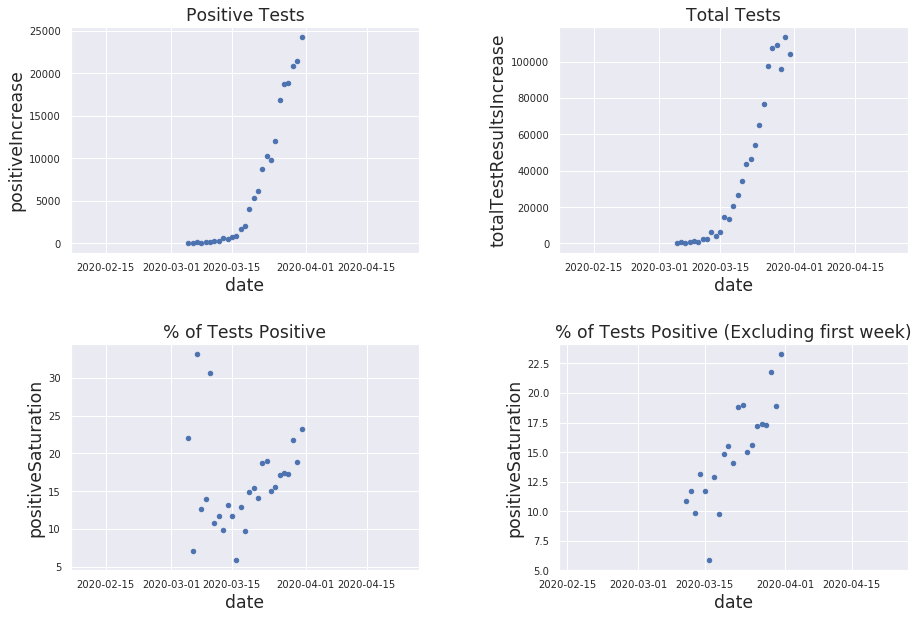

In [41]:
# ax = plt.gca()
# ax.set_title('US: Foo')

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)



ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title('Positive Tests')
usDaily.plot(label='Positive Tests', kind='scatter', x='date', y='positiveIncrease', legend=False, ax=ax1)

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title('Total Tests')
usDaily.plot(kind='scatter', x='date', y='totalTestResultsIncrease', legend=False, ax=ax2)

ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title('% of Tests Positive')
usDaily.plot(kind='scatter', x='date', y='positiveSaturation', legend=False, ax=ax3)

ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title('% of Tests Positive (Excluding first week)')
droppedNoise = usDaily.head(-7)
droppedNoise.plot(kind='scatter', x='date', y='positiveSaturation', legend=False, ax=ax4)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


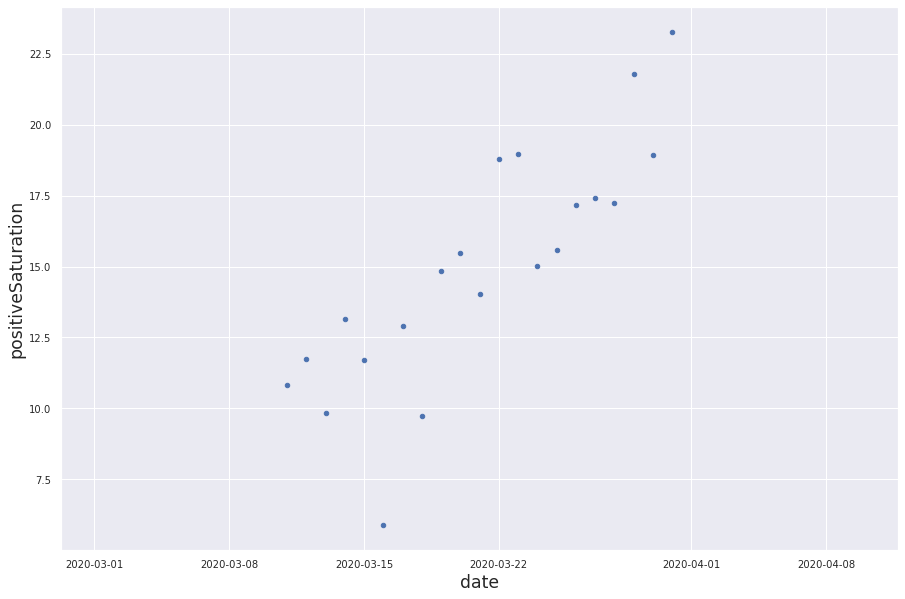

In [42]:
ax = plt.gca()

droppedNoise.plot(kind='scatter', x='date', y='positiveSaturation', legend=False, ax=ax)

## Fitting a line to positive saturation over time to predict possible first case

In [43]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

regressionModelOfAllData = ols("positiveSaturation ~ dayOfYear", data=usDaily).fit()

regressionModelOfAllData.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     positiveSaturation   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.3531
Date:                Wed, 01 Apr 2020   Prob (F-statistic):              0.558
Time:                        22:14:02   Log-Likelihood:                -87.191
No. Observations:                  27   AIC:                             178.4
Df Residuals:                      25   BIC:                             181.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.7886     12.304      0.714      0.482     -16.551      34.129
dayOfYear      0.0933      0.157      0.594      0.558      -0.230       0.417
==============================================================================
Omnibus:                       12.441   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               11.586
Skew:                           1.297   Prob(JB):                      0.00305
Kurtosis:                       4.890   Cond. No.                         789.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Analysis of regression on Full Dataset

R-squared of 0.014 is abysmal. 

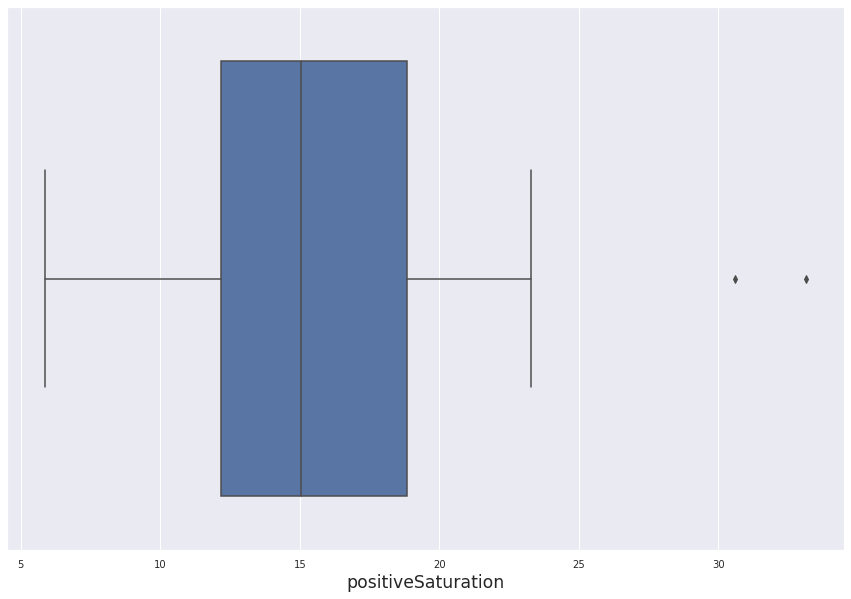

In [44]:
sns.boxplot(x=usDaily['positiveSaturation'])

In [45]:
#q1 = usDaily['positiveSaturation'].quantile(0.25)
#q3 = usDaily['positiveSaturation'].quantile(0.75)
#iqr = q3 - q1

#usDaily['positiveSaturationCorrected'] = usDaily['positiveSaturation'].clip( (q1 - 1.5 *iqr), (q3 + 1.5 * iqr) )

## Was not satisfied with the results of doing this statistically with zscores or IQR ...
# so throw out the first week of testing, based on it being over 2,000 tests/day

usDaily[['positiveSaturation', 'totalTestResultsIncrease']]

,positiveSaturation,totalTestResultsIncrease
0,23.281501,104117.0
1,18.914919,113503.0
2,21.774860,95647.0
3,17.255733,109071.0
4,17.408081,107295.0
5,17.184017,97806.0
6,15.587087,76820.0
7,15.024755,65239.0
8,18.978035,54131.0
9,18.777576,46236.0


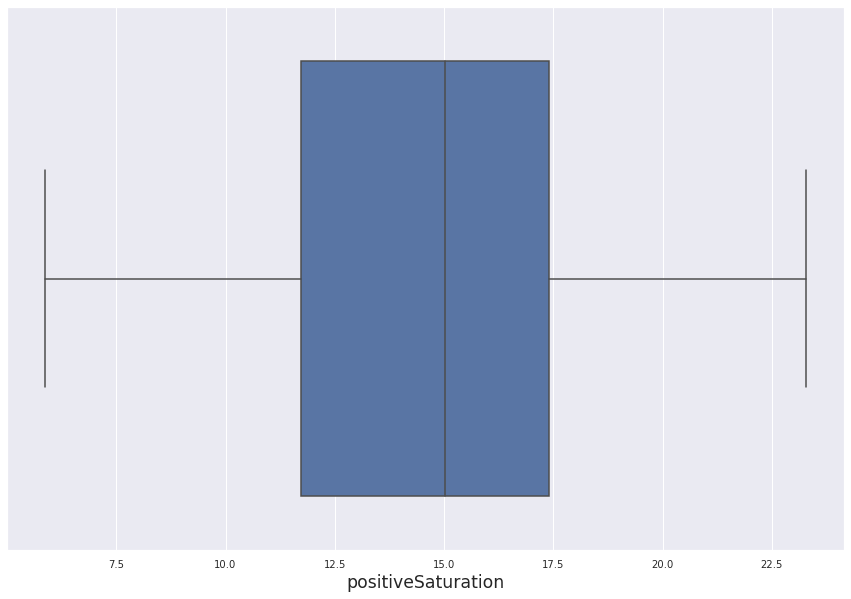

In [46]:
sns.boxplot(x=droppedNoise['positiveSaturation'])

In [47]:
regressionModel = ols("positiveSaturation ~ dayOfYear", data=droppedNoise).fit()
print(regressionModel.params)
regressionModel.summary()

#posSat = -31.57 + 0.574 * dayOfYear

Intercept   -31.572625
dayOfYear     0.574553
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     positiveSaturation   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     44.99
Date:                Wed, 01 Apr 2020   Prob (F-statistic):           2.07e-06
Time:                        22:14:03   Log-Likelihood:                -46.928
No. Observations:                  21   AIC:                             97.86
Df Residuals:                      19   BIC:                             99.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -31.5726      6.958     -4.538      0.000     -46.135     -17.010
dayOfYear      0.5746      0.086      6.708      0.000       0.395       0.754
==============================================================================
Omnibus:                        4.385   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.112   Jarque-Bera (JB):                2.503
Skew:                          -0.794   Prob(JB):                        0.286
Kurtosis:                       3.584   Cond. No.                     1.09e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
regressionModel.predict({"dayOfYear": 54})

# R^2 still isn't satsifying ... need more data
# Rough estimate of 54th day of the year for the first positive test, this could be +/- 10 days (February 23rd)

0   -0.546762
dtype: float64

<Figure size 1080x720 with 0 Axes>

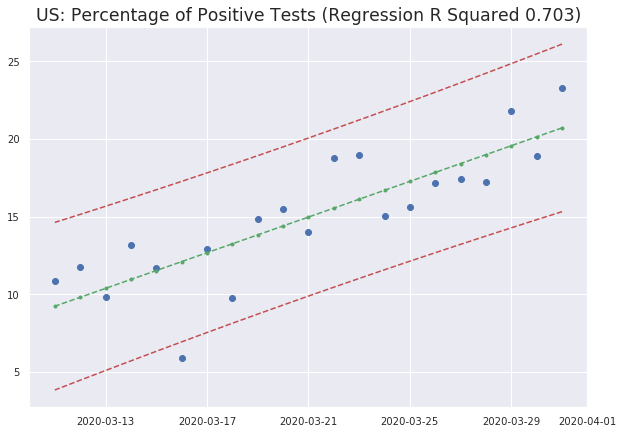

In [49]:
fig = plt.figure()

#sm.graphics.plot_regress_exog(regressionModel, "dayOfYear", fig=fig)


# predictor variable (x) and dependent variable (y)
x = droppedNoise[['date']]
y = droppedNoise[['positiveSaturation']]

# Retrieve our confidence interval values
# _ is a dummy variable since we don't actually use it for plotting but need it as a placeholder
# since wls_prediction_std(housing_model) returns 3 values
_, confidence_interval_lower, confidence_interval_upper = wls_prediction_std(regressionModel)

fig, ax = plt.subplots(figsize=(10,7))

ax.set_title("US: Percentage of Positive Tests (Regression R Squared " + str(round(regressionModel.rsquared, 3)) + ")")


# plot the dots
# 'o' specifies the shape (circle), we can also use 'd' (diamonds), 's' (squares)
ax.plot(x, y, 'o')

# Trend Line
ax.plot(x, regressionModel.fittedvalues, 'g--.')


ax.plot(x, confidence_interval_upper, 'r--')
ax.plot(x, confidence_interval_lower, 'r--')

#ax.legend(loc='best');

plt.savefig('covid_images/US_Positive_Tests_Over_Time.png', dpi=300)

# Looking at some more interesting saturations

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

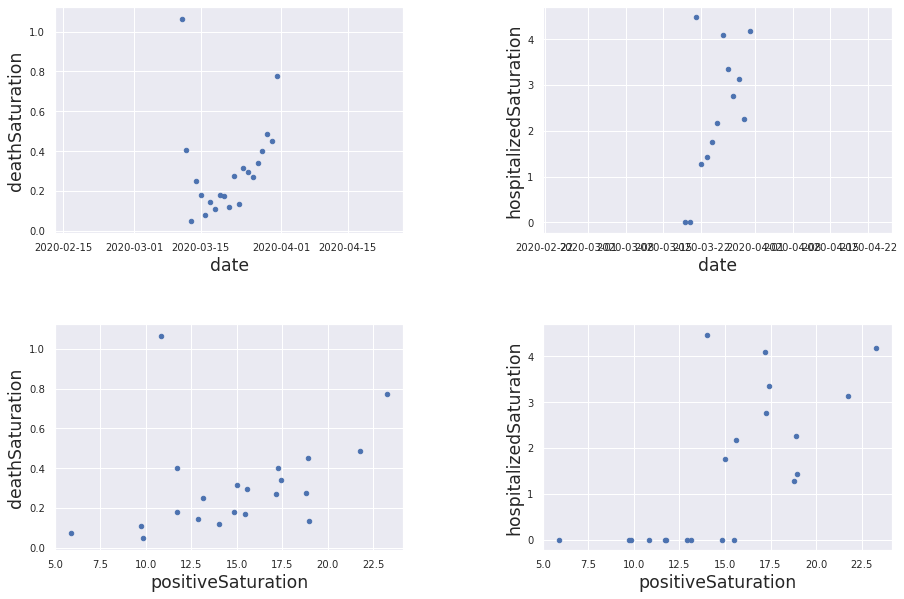

In [50]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

    
# Death Saturation: week, hospitalized

# Hospitalized Saturation: week, death, positive

# Negative Saturation: week

# Positive Saturation: week, death, hospitalized
    
    
ax1 = fig.add_subplot(2, 2, 1)
droppedNoise.plot(kind='scatter', x='date', y='deathSaturation',  ax=ax1)
ax2 = fig.add_subplot(2, 2, 2)
droppedNoise.head(-8).plot(kind='scatter', x='date', y='hospitalizedSaturation',  ax=ax2)
ax3 = fig.add_subplot(2, 2, 3)
droppedNoise.plot(kind='scatter', x='positiveSaturation', y='deathSaturation',  ax=ax3)
ax4 = fig.add_subplot(2, 2, 4)
droppedNoise.plot(kind='scatter', x='positiveSaturation', y='hospitalizedSaturation',  ax=ax4)